# BINARY NETWORK TRAFFIC ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

In [2]:
train = pd.read_table('KDDTrain+.txt',sep=',',header=None)
test = pd.read_table('KDDTest+.txt',sep=',',header=None)

feature_names = ['Duration', 'Protocol Type', 'Service', 'Flag', 'Source Bytes', 'Destination Bytes', 'Land', 'Wrong Fragment', 
                 'Urgent', 'Hot', 'Number Failed Logins', 'Login', 'Num compromised', 'Root Shell', 'Su attempted', 'Num root', 'Num file creations',
                'Num shells', 'Num access files', 'Num outbound cmds', 'Is host login', 'Is guest Login', 'Count', 'Srv Count', 'Serror rate',  'Srv Serror rate',
                'Rerror rate', 'Srv rerror rate', 'Same srv rate', 'Diff srv rate', 'Srv diff host rate', 'Dst host count', 'Dst host srv count', 'Dst host same srv rate',
                'Dst host diff srv rate', 'Dst host same src port rate', 'Dst host diff src host rate', 'Dst host serror rate', 'Dst host srv serror rate', 
                'Dst host rerror rate', 'Dst host srv rerror rate', 'Class Label', 'Difficulty']

train.columns = feature_names
test.columns = feature_names

In [3]:
train.isnull().sum()

Duration                       0
Protocol Type                  0
Service                        0
Flag                           0
Source Bytes                   0
Destination Bytes              0
Land                           0
Wrong Fragment                 0
Urgent                         0
Hot                            0
Number Failed Logins           0
Login                          0
Num compromised                0
Root Shell                     0
Su attempted                   0
Num root                       0
Num file creations             0
Num shells                     0
Num access files               0
Num outbound cmds              0
Is host login                  0
Is guest Login                 0
Count                          0
Srv Count                      0
Serror rate                    0
Srv Serror rate                0
Rerror rate                    0
Srv rerror rate                0
Same srv rate                  0
Diff srv rate                  0
Srv diff h

In [4]:
train_target = train['Class Label']
train_target_labels = train_target.unique().tolist()
train_attacks = train_target_labels.remove('normal')
train['Class Label'] = train['Class Label'].replace([i for i in train_target_labels],'attack')

In [5]:
test_target = test['Class Label']
test_target_labels = test_target.unique().tolist()
test_attacks = test_target_labels.remove('normal')
test['Class Label'] = test['Class Label'].replace([i for i in test_target_labels],'attack')

In [6]:
categorical_features = [feature for feature in train if train[feature].dtype == 'object']
numerical_features = [feature for feature in train if train[feature].dtype != 'object']

### Data Preprocessing

In [7]:
class_map = {'normal':0,'attack':1}
train['Class Label'] = train['Class Label'].map(class_map)
test['Class Label'] = test['Class Label'].map(class_map)

In [8]:
data = pd.concat([train,test],axis=0)

In [9]:
def correl(data):
    corr = data.corr()
    results = corr['Class Label'].sort_values(ascending=False)
    
    return results

In [10]:
correl(data)

Class Label                    1.000000
Dst host srv serror rate       0.593690
Dst host serror rate           0.589936
Serror rate                    0.588474
Srv Serror rate                0.586636
Count                          0.524108
Dst host count                 0.373459
Dst host rerror rate           0.300751
Rerror rate                    0.300664
Srv rerror rate                0.299129
Dst host srv rerror rate       0.297977
Dst host diff srv rate         0.244649
Diff srv rate                  0.215802
Wrong Fragment                 0.081696
Dst host same src port rate    0.081468
Dst host diff src host rate    0.053079
Duration                       0.052119
Number Failed Logins           0.042730
Land                           0.008817
Is host login                  0.007835
Source Bytes                   0.005457
Urgent                         0.003862
Is guest Login                 0.003839
Destination Bytes              0.003583
Num shells                    -0.000259


## Weight Encoding

In [11]:
data_service = data['Service'].value_counts()/data['Service'].value_counts().sum()
data_service_map = dict(data_service)

data['Service'] = data['Service'].map(data_service_map) 

In [12]:
#protocol encoding
protocol_dummies_data = pd.get_dummies(data['Protocol Type']).add_suffix('_Protocol')
data = pd.concat([data,protocol_dummies_data],axis=1).drop('Protocol Type',axis=1)

#flag encoding
flag_dummies_data = pd.get_dummies(data['Flag']).add_suffix('_Flag')
data = pd.concat([data,flag_dummies_data],axis=1).drop('Flag',axis=1)

In [13]:
data['Class Label'].value_counts()

0    77054
1    71463
Name: Class Label, dtype: int64

In [14]:
def get_quartiles(column):
    q1, q3 = np.percentile(data[column], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    return lower_bound,upper_bound

In [15]:
def log_adjust(column):
    
    fill = []
    
    b1,b2 = get_quartiles(column)
    for i in data[column]:
        if i>b2:
            fill.append(np.log(i))
        else:
            fill.append(i)
            
    return fill        

In [16]:
data['Log_num_compromised'] = log_adjust('Num compromised')
data['Count'] = log_adjust('Count')
data['Log_Srv_count'] = log_adjust('Srv Count')
data['Log_file_creations'] = log_adjust('Num file creations')

In [17]:
data.drop(['Num compromised','Count','Srv Count','Num file creations'],axis=1,inplace=True)

### Modelling

In [18]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score
import xgboost as xgb
import lightgbm as lgb

In [19]:
new_train = data[:train.shape[0]]
new_test = data[train.shape[0]:]

In [20]:
target = new_train['Class Label']
X = new_train.drop(['Class Label'], axis=1)

In [21]:
test_target = new_test['Class Label']
test_data = new_test.drop(['Class Label'], axis=1)

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X.values, target.values, random_state=16)

In [23]:
X_train.shape

(94479, 53)

In [24]:
y_train.shape

(94479,)

In [25]:
X_test.shape

(31494, 53)

In [26]:
y_test.shape

(31494,)

## Logistic Regression

In [27]:
pipe_lr = make_pipeline(MinMaxScaler(),
                         SelectPercentile(percentile=50),LogisticRegression(C=100,max_iter=1000))

In [28]:
pipe_lr.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000001EF6E0F48B8>)),
                ('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [29]:
pred_test = pipe_lr.predict(X_test)

In [30]:
confusion = confusion_matrix(y_test, pred_test)
print('Train Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train Result

Confusion matrix:
[[16451   351]
 [  348 14344]]

              precision    recall  f1-score   support

      normal       0.98      0.98      0.98     16802
      attack       0.98      0.98      0.98     14692

    accuracy                           0.98     31494
   macro avg       0.98      0.98      0.98     31494
weighted avg       0.98      0.98      0.98     31494



In [31]:
prediction = pipe_lr.predict(test_data)

In [32]:
accuracy_score(test_target,prediction)

0.8707860184528035

In [33]:
confusion = confusion_matrix(test_target,prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9313   398]
 [ 2515 10318]]

              precision    recall  f1-score   support

      normal       0.79      0.96      0.86      9711
      attack       0.96      0.80      0.88     12833

    accuracy                           0.87     22544
   macro avg       0.88      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544



In [38]:
prediction=pipe_lr.predict(test_data)

In [39]:
confusion = confusion_matrix(prediction,test_target)

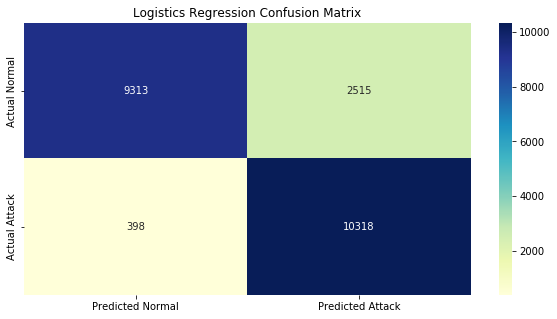

In [40]:
plt.subplots(figsize=(10,5))
plt.title('Logistics Regression Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## RANDOM FOREST

In [41]:
pipe_rf = make_pipeline(SelectPercentile(percentile=25),
                        RandomForestClassifier(n_estimators=150,max_depth=5,random_state=16))

In [42]:
pipe_rf.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function f_classif at 0x000001EF6E0F48B8>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=16,
                             

In [43]:
pred_test = pipe_rf.predict(X_test)

In [44]:
confusion = confusion_matrix(pred_test,y_test)
print('Train Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train Result

Confusion matrix:
[[16579   293]
 [  223 14399]]

              precision    recall  f1-score   support

      normal       0.98      0.99      0.98     16802
      attack       0.98      0.98      0.98     14692

    accuracy                           0.98     31494
   macro avg       0.98      0.98      0.98     31494
weighted avg       0.98      0.98      0.98     31494



In [45]:
rf_prediction = pipe_rf.predict(test_data)

In [46]:
accuracy_score(test_target,rf_prediction)

0.8772178850248403

In [47]:
confusion = confusion_matrix(test_target,prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9313   398]
 [ 2515 10318]]

              precision    recall  f1-score   support

      normal       0.79      0.96      0.86      9711
      attack       0.96      0.80      0.88     12833

    accuracy                           0.87     22544
   macro avg       0.88      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544



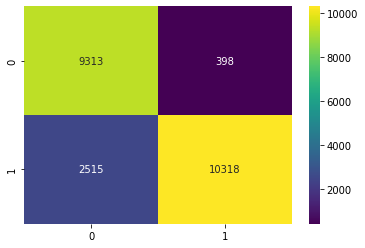

In [48]:
sns.heatmap(confusion,fmt='d',annot=True,cmap='viridis')

In [49]:
prediction = pipe_rf.predict(test_data)
confusion = confusion_matrix(prediction,test_target)

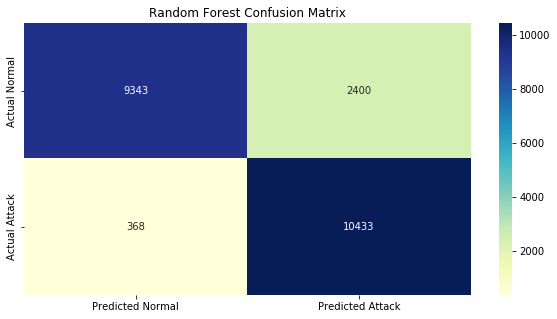

In [50]:
plt.subplots(figsize=(10,5))
plt.title('Random Forest Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## Gradient Boosting 

In [51]:
pipe_gb = make_pipeline(SelectPercentile(percentile=25),
                        GradientBoostingClassifier(n_estimators = 150, max_features='log2',max_depth = 7,learning_rate=0.2,random_state=16))

In [52]:
pipe_gb.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function f_classif at 0x000001EF6E0F48B8>)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.2, loss='deviance',
                                            max_depth=7, max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_es

In [53]:
pred_test = pipe_gb.predict(X_test)

In [54]:
confusion = confusion_matrix(pred_test,y_test)
print('Train\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train

Confusion matrix:
[[16782    23]
 [   20 14669]]

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     16802
      attack       1.00      1.00      1.00     14692

    accuracy                           1.00     31494
   macro avg       1.00      1.00      1.00     31494
weighted avg       1.00      1.00      1.00     31494



In [55]:
gb_prediction = pipe_gb.predict(test_data)

In [56]:
accuracy_score(test_target,gb_prediction)

0.870874733853797

In [57]:
confusion = confusion_matrix(test_target,prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9343   368]
 [ 2400 10433]]

              precision    recall  f1-score   support

      normal       0.80      0.96      0.87      9711
      attack       0.97      0.81      0.88     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544



In [58]:
prediction = pipe_gb.predict(test_data)
confusion = confusion_matrix(prediction,test_target)

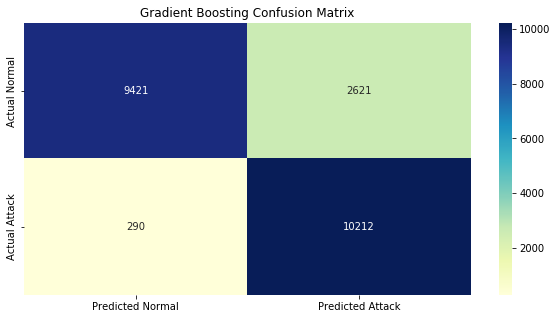

In [59]:
plt.subplots(figsize=(10,5))
plt.title('Gradient Boosting Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## XGBOOST

In [27]:
pipe_xgb = make_pipeline(SelectPercentile(percentile=25),
                         xgb.XGBClassifier(n_estimators=150,learning_rate=0.1,max_depth=5,random_state=16))

In [28]:
pipe_xgb.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Pipeline(memory=None,
         steps=[('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function f_classif at 0x0000028704AE8828>)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_i...='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_es

In [29]:
pred_test = pipe_xgb.predict(X_test)

In [30]:
confusion = confusion_matrix(pred_test,y_test)
print('Train Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train Result

Confusion matrix:
[[16755    26]
 [   47 14666]]

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     16802
      attack       1.00      1.00      1.00     14692

    accuracy                           1.00     31494
   macro avg       1.00      1.00      1.00     31494
weighted avg       1.00      1.00      1.00     31494



In [31]:
xgb_prediction = pipe_xgb.predict(test_data)

In [32]:
accuracy_score(test_target,xgb_prediction)

0.877040454222853

In [34]:
confusion = confusion_matrix(test_target,xgb_prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,xgb_prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9312   399]
 [ 2373 10460]]

              precision    recall  f1-score   support

      normal       0.80      0.96      0.87      9711
      attack       0.96      0.82      0.88     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544



In [35]:
prediction = pipe_xgb.predict(test_data)
confusion = confusion_matrix(prediction,test_target)

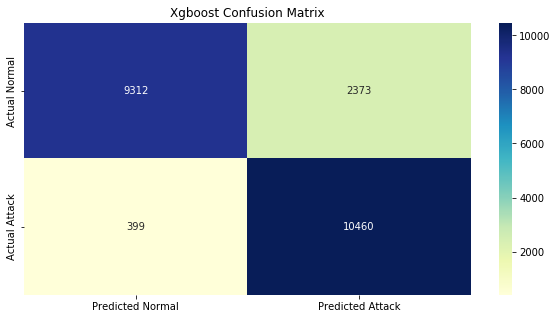

In [38]:
plt.subplots(figsize=(10,5))
plt.title('Xgboost Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## LIGHTGBM

In [69]:
pipe_lgb = make_pipeline(SelectPercentile(percentile=25),
                         lgb.LGBMClassifier(num_iterations=150,
                                            max_depth=5,learning_rate=0.1,random_state=16))


In [70]:
pipe_lgb.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\ben\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Pipeline(memory=None,
         steps=[('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function f_classif at 0x000001EF6E0F48B8>)),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=5,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_iterations=150, num_leaves=31,
                                objective=None, random_state=16, reg_alpha=0.0,
                                reg_lambda=0.0, silent='warn', subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [71]:
pred_test = pipe_lgb.predict(X_test)

In [72]:
confusion = confusion_matrix(pred_test,y_test)
print('Train Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train Result

Confusion matrix:
[[16753    21]
 [   49 14671]]

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     16802
      attack       1.00      1.00      1.00     14692

    accuracy                           1.00     31494
   macro avg       1.00      1.00      1.00     31494
weighted avg       1.00      1.00      1.00     31494



In [73]:
lgb_prediction = pipe_lgb.predict(test_data)

In [74]:
accuracy_score(test_target,lgb_prediction)

0.8671486870120653

In [75]:
confusion = confusion_matrix(test_target,prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9312   399]
 [ 2373 10460]]

              precision    recall  f1-score   support

      normal       0.80      0.96      0.87      9711
      attack       0.96      0.82      0.88     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544



In [76]:
prediction = pipe_lgb.predict(test_data)
confusion = confusion_matrix(prediction,test_target)

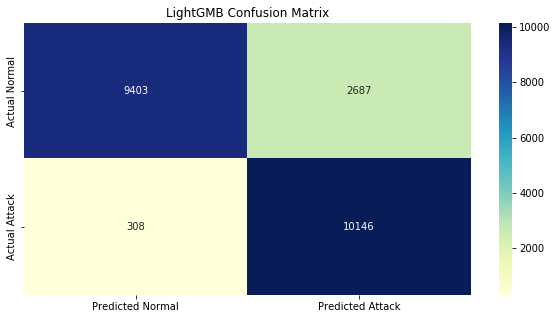

In [77]:
plt.subplots(figsize=(10,5))
plt.title('LightGMB Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## SVM

In [78]:
pipe_svm = make_pipeline(MinMaxScaler(),
                    SelectPercentile(percentile=50),SVC(C = 1000, gamma = 0.5, max_iter=1000, 
                                                        random_state=16,probability=True))

In [79]:
pipe_svm.fit(X_train,y_train)

C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [15 16] are constant.
  UserWarning)
C:\Users\ben\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\ben\anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function f_classif at 0x000001EF6E0F48B8>)),
                ('svc',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.5,
                     kernel='rbf', max_iter=1000, probability=True,
                     random_state=16, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [80]:
pred_test = pipe_svm.predict(X_test)

In [81]:
confusion = confusion_matrix(pred_test,y_test)
print('Train Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(y_test, pred_test,target_names=["normal", "attack"]))

Train Result

Confusion matrix:
[[16726  6431]
 [   76  8261]]

              precision    recall  f1-score   support

      normal       0.72      1.00      0.84     16802
      attack       0.99      0.56      0.72     14692

    accuracy                           0.79     31494
   macro avg       0.86      0.78      0.78     31494
weighted avg       0.85      0.79      0.78     31494



In [82]:
svm_prediction = pipe_svm.predict(test_data)

In [83]:
accuracy_score(test_target,prediction)

0.8671486870120653

In [84]:
confusion = confusion_matrix(test_target,prediction)
print('Test Result\n')
print("Confusion matrix:\n{}\n".format(confusion))

print(classification_report(test_target,prediction,target_names=["normal", "attack"]))

Test Result

Confusion matrix:
[[ 9403   308]
 [ 2687 10146]]

              precision    recall  f1-score   support

      normal       0.78      0.97      0.86      9711
      attack       0.97      0.79      0.87     12833

    accuracy                           0.87     22544
   macro avg       0.87      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544



In [85]:
prediction = pipe_svm.predict(test_data)
confusion = confusion_matrix(prediction,test_target)

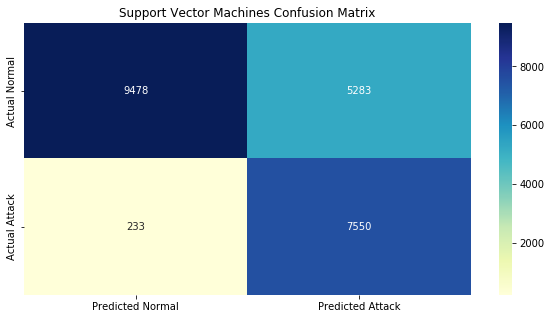

In [86]:
plt.subplots(figsize=(10,5))
plt.title('Support Vector Machines Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## Fit Check

In [ ]:
def fitting(model):
    
    train_score= model.score(X_train,y_train)
    test_score= model.score(X_test,y_test)
    
    print('Train set score:{:.3f}'.format(train_score))
    print('Test set score:{:.3f}'.format(test_score))
    
    if (train_score-test_score) >= 0.1:
        print('Model is overfitted')
    elif (train_score-test_score) < 0: 
        print('Model is underfitted')
    else:
        print('Proper fit prediction')

In [ ]:
fitting(pipe_lr)

In [ ]:
fitting(pipe_rf)

In [ ]:
fitting(pipe_gb)

In [ ]:
fitting(pipe_xgb)

In [ ]:
fitting(pipe_lgb)

## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting_clf = VotingClassifier(estimators=[('xgb',pipe_xgb),('rf',pipe_rf),('gb',pipe_gb),('lgb',pipe_lgb)],
                             voting = 'hard')

In [ ]:
voting_clf.fit(X_train,y_train)

In [ ]:
predict = voting_clf.predict(test_data)

In [ ]:
accuracy_score(test_target,predict)

In [ ]:
print(classification_report(test_target,predict))

In [ ]:
confussion = confusion_matrix(test_target,predict)

In [ ]:
plt.subplots(figsize=(10,5))
plt.title('Gradient Boosting Confusion Matrix')
sns.heatmap(confusion,fmt='d',annot=True,cmap='YlGnBu',
            xticklabels=['Predicted Normal','Predicted Attack'], yticklabels=['Actual Normal','Actual Attack'])

## Cross Validation

In [ ]:
kfold = StratifiedKFold(n_splits =5, shuffle=True, random_state=16)

In [ ]:
def validate(model,x,y):
    
    scores = cross_val_score(model, x, y, cv=kfold)
    
    print(model)    
    print(scores)
    print(scores.mean())
    
    result = scores.mean()
    
    return result

### Train Validation

In [ ]:
validate(pipe_lr,X,target)

In [ ]:
validate(pipe_rf,X,target)

In [ ]:
validate(pipe_gb,X,target)

In [ ]:
validate(pipe_xgb,X,target)

In [ ]:
validate(pipe_lgb,X,target)

In [ ]:
validate(pipe_svm,X,target)

### Test Validation

In [ ]:
validate(pipe_lr,test_data,test_target)

In [ ]:
validate(pipe_rf,test_data,test_target)

In [ ]:
validate(pipe_gb,test_data,test_target)

In [ ]:
validate(pipe_xgb,test_data,test_target)

In [ ]:
validate(pipe_lgb,test_data,test_target)

In [ ]:
validate(pipe_svm,test_data,test_target)

In [ ]:
train_scores_lr,test_score_lr = validate(pipe_lr,X,target),validate(pipe_lr,test_data,test_target)
train_scores_rf,test_score_rf = validate(pipe_rf,X,target),validate(pipe_rf,test_data,test_target)
train_scores_gb,test_score_gb = validate(pipe_gb,X,target),validate(pipe_gb,test_data,test_target)
train_scores_xgb,test_score_xgb = validate(pipe_xgb,X,target),validate(pipe_xgb,test_data,test_target)
train_scores_lgb,test_score_lgb = validate(pipe_lgb,X,target),validate(pipe_lgb,test_data,test_target)
train_scores_svm,test_score_svm = validate(pipe_svm,X,target),validate(pipe_svm,test_data,test_target)

### Evaluation

In [ ]:
eval_result = {'Logistic Regression':[train_scores_lr,test_score_lr],'Random Forest':[train_scores_rf,test_score_rf],
      'Gradient Boosting':[train_scores_gb,test_score_gb],
      'Xgboost':[train_scores_xgb,test_score_xgb],'LightGBM':[train_scores_lgb,test_score_lgb],
      'SVM':[train_scores_svm,test_score_svm],'ANN':[0.971398,0.992548]
     }

df = pd.DataFrame(eval_result)

#df.plot(kind='bar')
#plt.legend(['Train','Test'],loc=0)

In [ ]:
new_df = df.T
new_df = new_df.rename(columns={0:'Train',1:'Test'})

In [ ]:
new_df

In [ ]:
new_df.to_excel('accuracy.xlsx')

In [ ]:
fig,ax = plt.subplots(figsize=(25,17))
new_df.plot(kind='bar',ax=ax,fig = (plt.ylim(0.75,1.0),plt.title('Evaluation',size=30),plt.xlabel('Models',size=20,),
                                    plt.ylabel('Accuracies',size=20),plt.yticks(fontsize=20)))
plt.xticks(fontsize=20,rotation=15)
fig.savefig('Binary Accuracy Evaluation')